In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import f1_score

In [68]:
#Convert json file to DataFrame
train = pd.read_json("train.json")
test = pd.read_json("test.json")

# Exploratory Data Analysis

In [69]:
train.describe()

,id
count,39774.000000
mean,24849.536959
std,14360.035505
min,0.000000
25%,12398.250000
50%,24887.000000
75%,37328.500000
max,49717.000000


In [70]:
train.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


#### Distribution of Cuisines

In [71]:
cuisines = train['cuisine'].value_counts() #Create a Series of cuisines with number of instances in the DataFrame

C:\Users\home\AppData\Local\Temp\ipykernel_8436\2038247357.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x=cuisines.values,y=cuisines.index,palette="viridis")


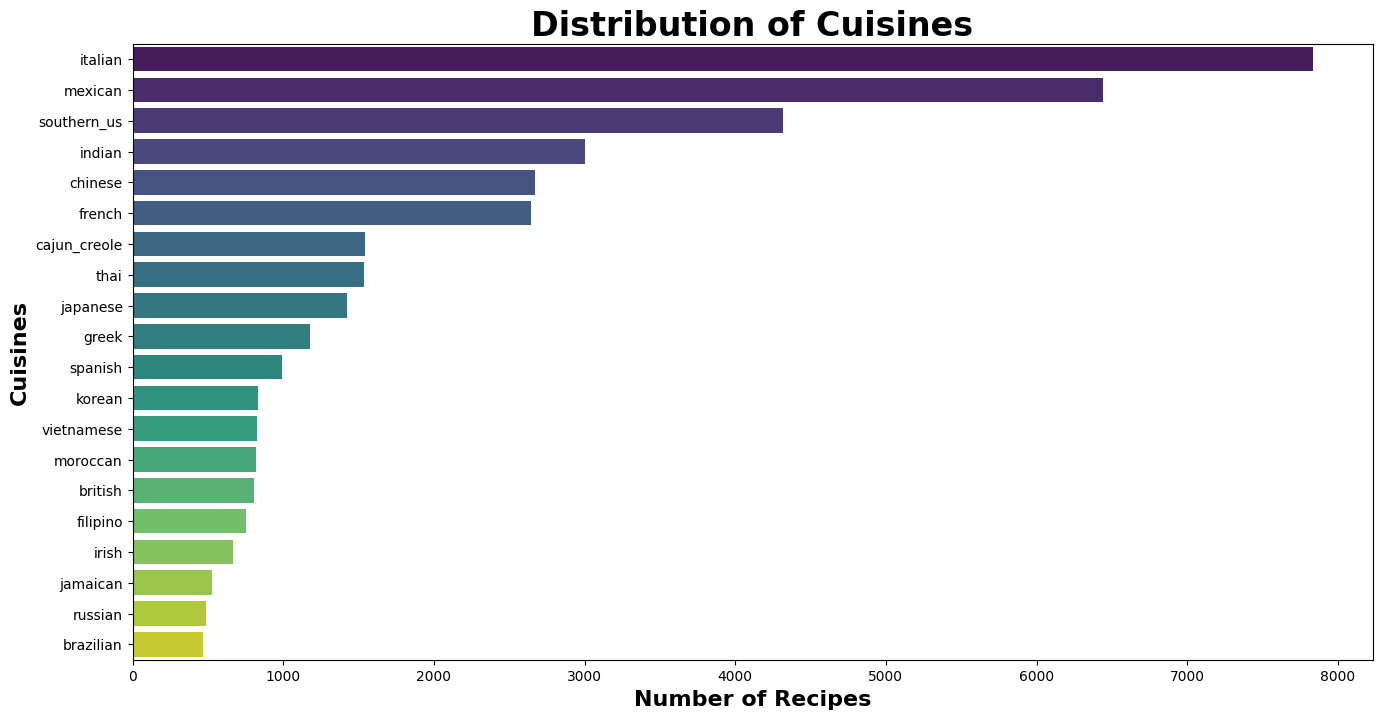

In [72]:
#Turn the cuisine count Series into a Bar Graph
plt.figure(figsize=(16,8))
sb.barplot(x=cuisines.values,y=cuisines.index,palette="viridis")
plt.title("Distribution of Cuisines", fontsize=24, fontweight="bold")
plt.xlabel("Number of Recipes", fontsize=16, fontweight="bold")
plt.ylabel("Cuisines", fontsize=16, fontweight="bold")
plt.show()


#### Most Common Ingredients

In [73]:
#Create a Series of instances of each ingredients, and get the most common 20
ingredient_list = train['ingredients'].explode()
sorted_ingredients = ingredient_list.value_counts()
sorted_ingredients = sorted_ingredients[:20]

C:\Users\home\AppData\Local\Temp\ipykernel_8436\3136166340.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x=sorted_ingredients.values,y=sorted_ingredients.index,palette="viridis")


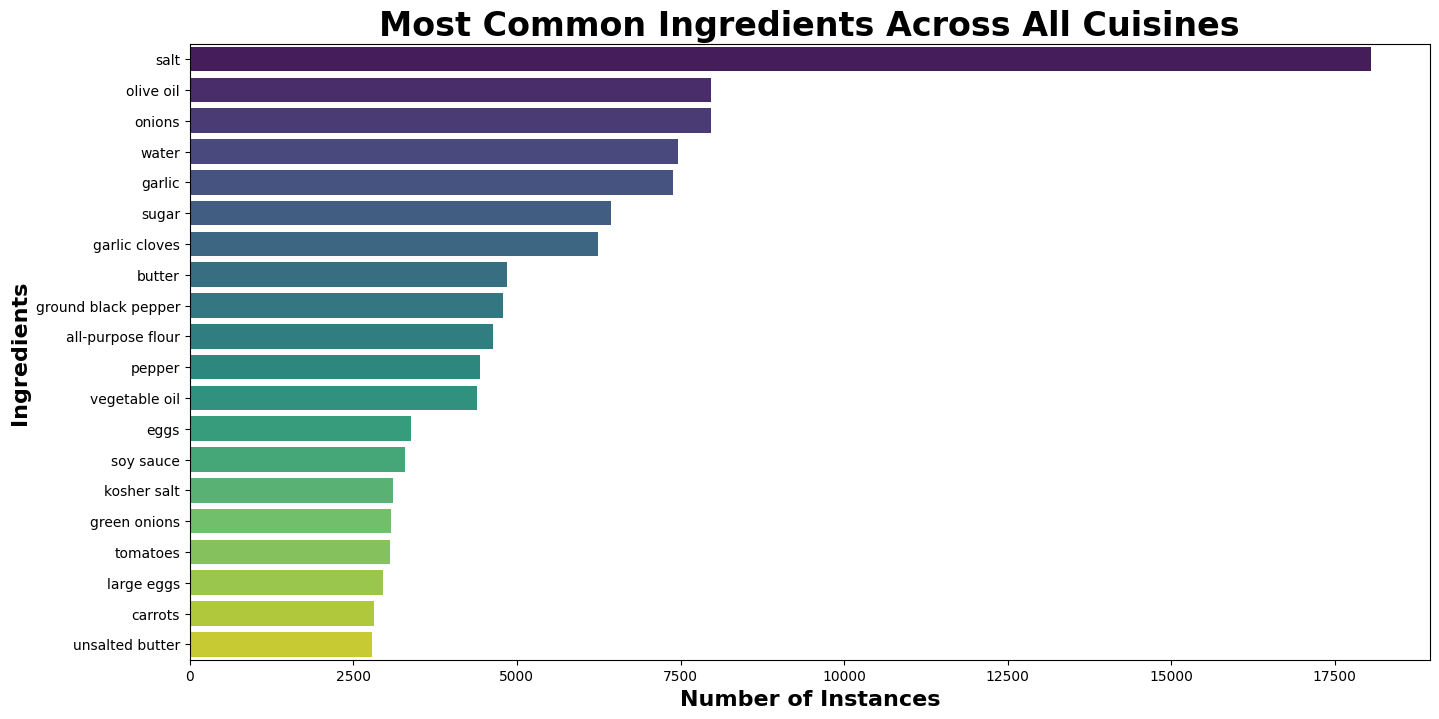

In [74]:
#Turn the ingredient count Series into a Bar Graph
plt.figure(figsize=(16,8))
sb.barplot(x=sorted_ingredients.values,y=sorted_ingredients.index,palette="viridis")
plt.title("Most Common Ingredients Across All Cuisines", fontsize=24, fontweight="bold")
plt.xlabel("Number of Instances", fontsize=16, fontweight="bold")
plt.ylabel("Ingredients", fontsize=16, fontweight="bold")
plt.show()

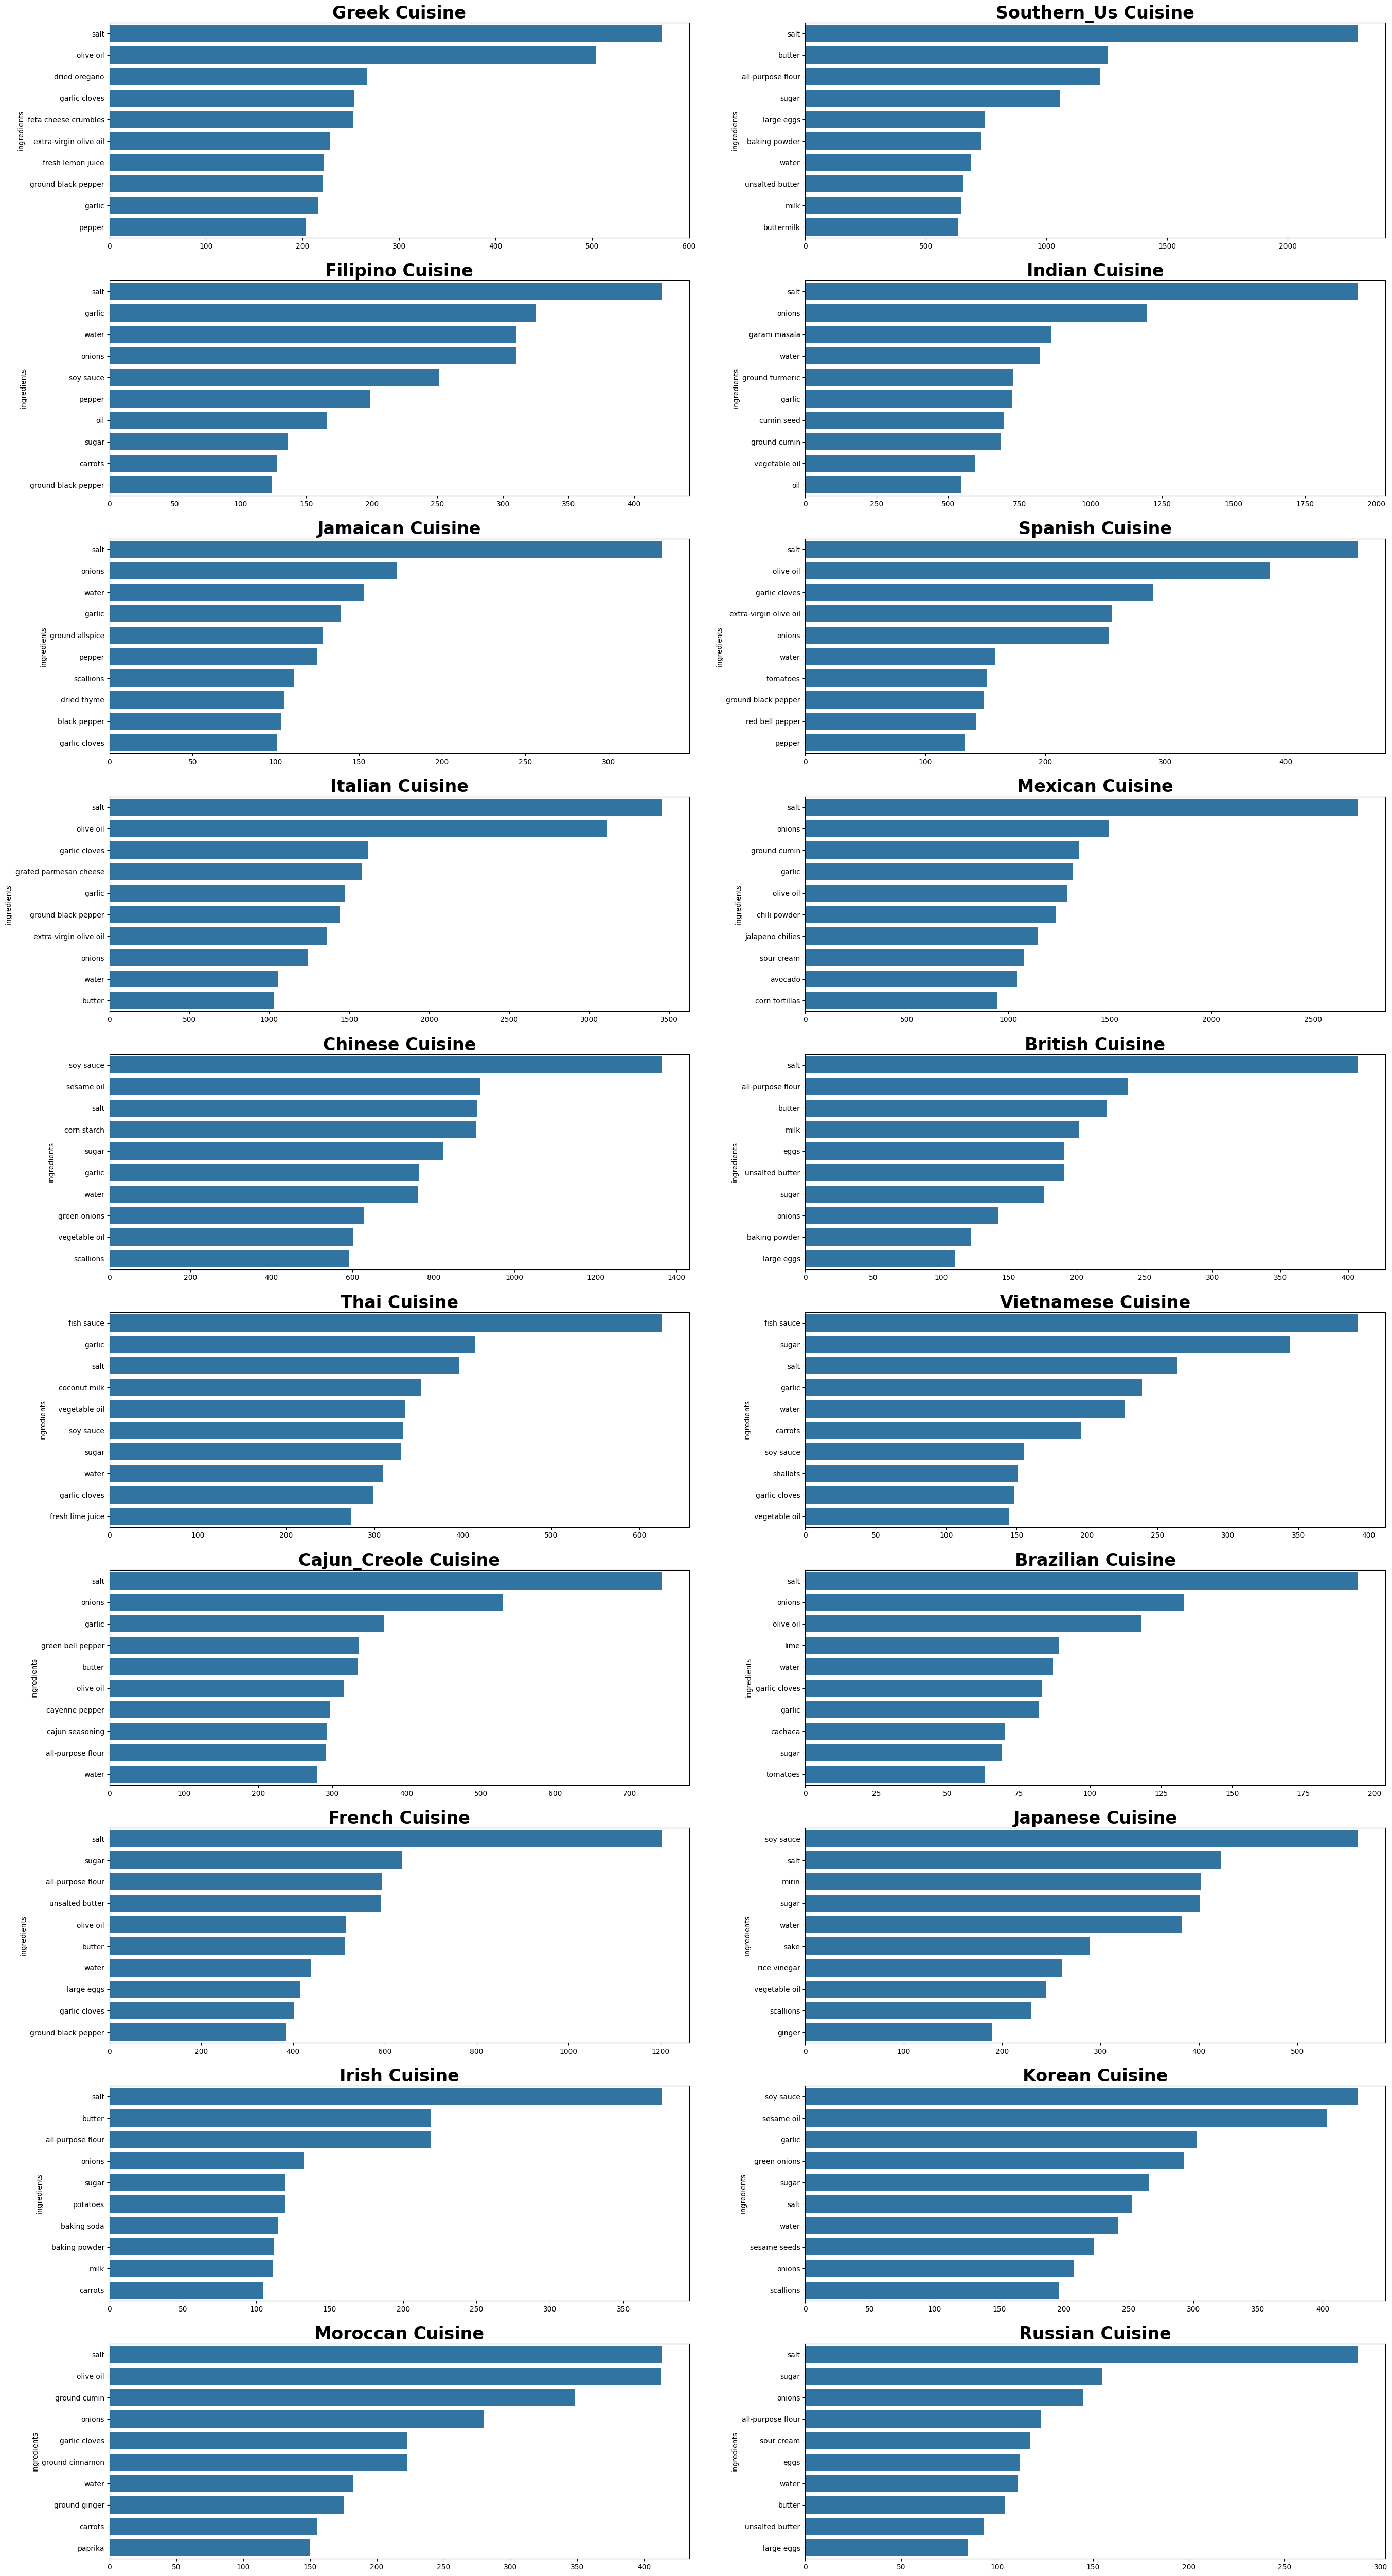

In [75]:
#Create a Series of instances of each ingredients for each cuisine, and get the most common 20
cuisine_ingredients = {}
for cuisine in train['cuisine'].unique():
    ingredient_list = train[train['cuisine']==cuisine]['ingredients'].explode()
    sorted_ingredients = ingredient_list.value_counts()
    sorted_ingredients = sorted_ingredients[:10]
    cuisine_ingredients[cuisine] = sorted_ingredients


#Turn each ingredient count Series into a Bar Graph for each cuisine
f, axes = plt.subplots((len(cuisines)+1)//2, 2, figsize=(32, 64))

count = 0
index = 0
for cuisine in cuisine_ingredients:
    ings = cuisine_ingredients[cuisine]
    plot = sb.barplot(x=ings.values,y=ings.index, ax = axes[count,index])
    plot.set_title(cuisine.title()+" Cuisine", fontsize=24, fontweight="bold")
    index += 1
    if index>1:
        index=0
        count += 1

# Data Processing

In [ ]:
#Format ingredients to work in vectorization
def preprocess_df(df):
    
    def process_string(text):
        for i in range(len(text)):
            word = text[i]
            #print(word,end='=>')
            word = re.sub(r'\(|\)', '', word) #Remove anything with brackets
            word = re.sub(r'[^\w]', '', word) #Remove special characters
            word = word.lower()
            text[i] = word
            #print(word)
        #print(text,end="=>")
        text = ' '.join(text)
        #print(text)
        return text
    
    df = df.drop('id',axis=1) #Remove redundant index
    df['ingredients'] = df['ingredients'].apply(process_string)
    
    return df

In [150]:
def get_cuisine_ingredients(df):
    cuisine_df = pd.DataFrame(columns=['ingredients'])
    for cus in df['cuisine'].unique():
        text = ""
        for x in df[df.cuisine == cus]['ingredients']:
            text += x
            text += " "
        cuisine_df.loc[cus,'ingredients'] = text

    cuisine_df = cuisine_df.reset_index()
    cuisine_df = cuisine_df.rename(columns ={'index':'cuisine'})
    return cuisine_df

In [148]:
trainDF = preprocess_df(train)
testDF = preprocess_df(test)

cuisineDF = get_cuisine_ingredients(trainDF)

Empty DataFrame
Columns: [ingredients]
Index: []


In [123]:
trainDF.head()

,cuisine,ingredients
0,greek,romainelettuce blackolives grapetomatoes garli...
1,southern_us,plainflour groundpepper salt tomatoes groundbl...
2,filipino,eggs pepper salt mayonaise cookingoil greenchi...
3,indian,water vegetableoil wheat salt
4,indian,blackpepper shallots cornflour cayennepepper o...


In [149]:
cuisineDF

,cuisine,ingredients
0,greek,romainelettuce blackolives grapetomatoes garli...
1,southern_us,plainflour groundpepper salt tomatoes groundbl...
2,filipino,eggs pepper salt mayonaise cookingoil greenchi...
3,indian,water vegetableoil wheat salt blackpepper shal...
4,jamaican,plainflour sugar butter eggs freshgingerroot s...
5,spanish,oliveoil salt mediumshrimp pepper garlic chopp...
6,italian,sugar pistachionuts whitealmondbark flour vani...
7,mexican,oliveoil purpleonion freshpineapple pork pobla...
8,chinese,lowsodiumsoysauce freshginger drymustard green...
9,british,greekyogurt lemoncurd confectionerssugar raspb...


In [154]:
#Function to obtain normalized count from a string of ingredients
def tfidf_vectorizer(train, test=None):
    tfidf = TfidfVectorizer(stop_words='english',
                             ngram_range = ( 1 , 1 ),analyzer="word", 
                             max_df = .57 , binary=False , token_pattern=r'\w+' , sublinear_tf=False)
    train = tfidf.fit_transform(train)
    if test is None: return train,tfidf
    test = tfidf.transform(test)
    return train, test, tfidf

In [155]:
train_tfidf, test_tfidf, tfidf = tfidf_vectorizer(train,test)
cuisine_data_tfidf, cuisine_tfidf = tfidf_vectorizer(cuisineDF['ingredients'])

# Modeling

In [ ]:
#ingredient_list.to_csv('ingredients.csv',header=False,index=False)